<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/simple_neighbourhood_search_two_dim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.special import erf

import matplotlib.pyplot as plt

import time
import glob
import os
import gc

In [2]:
# @title Simulations (functions)

def grf_2d(mean, std_dev, pixel, amplitude, k_power):
    # Generate white noise in-place
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel))

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = np.fft.fft2(white_noise)
    del white_noise
    gc.collect()

    # Generating FFT momentum
    kx = np.fft.fftfreq(pixel) * pixel
    ky = np.fft.fftfreq(pixel) * pixel

    # Generating FFT momentum 2D array
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    del kx, ky
    gc.collect()

    # Norm of k
    k_norm = np.sqrt(kx_grid**2 + ky_grid**2)
    k_norm[0, 0] = np.inf  # Regularize divergence at k=0
    del kx_grid, ky_grid
    gc.collect()

    # Power Spectrum P_k
    power_spectrum = amplitude * (((2 * np.pi / pixel) * k_norm) ** (-k_power))
    del k_norm  # Free memory
    gc.collect()

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = np.sqrt(power_spectrum, out=power_spectrum) * fft_white_noise
    del power_spectrum, fft_white_noise  # Free memory
    gc.collect()

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifft2(fourier_amplitudes_sqrt).real
    del fourier_amplitudes_sqrt  # Free memory
    gc.collect()

    return gaussian_random_field


def gaussian_to_exp(x, lam):
    mu = np.mean(x)
    sigma = np.std(x)
    xu = 0.5 * (1 + erf((x - mu) / (np.sqrt(2) * sigma)))
    return -1/lam  * np.log(1 - xu)


In [20]:
# @title Mass conversion (functions)



def filtering(x,y,pixel):
    """
    Mask for filtering out pixels outside the simulation box.
    """
    mask = (x >= 0) & (x < pixel) & (y >= 0) & (y < pixel)
    return x[mask], y[mask]


def M(c2, c1, threshold):

    """
    First input : above-threshold overdensity
    Second input : above-threshold overdensity



    Define
    M[delta2, delta1]:=0.0311926 (4.25699 + delta1)^4.59551 delta2^4.12181
    If[delta1 <= 0.599,
    HeavisideTheta[delta2 - 0.002/(delta1 - 0.6) - 0.6], 1]

    delta2 (c2) is the amplitude of the above-threshold overdensity,
    delta1 (c1) is the amplitude of an overdensity in one of the
    nearest-neighbouring patches.

    For each nearest-neighbouring patch add deltaM to the mass
    of the "bare" above-threshold patch, M[0,delta2],
    to get the total mass in units of the horizon mass.

    """


    """
    linearly re-scale the amplitudes delta1 and delta2 such that
    0.6 corresponds to the utilised threshold value (at a given rareness).
    """

    c1 = 0.6 * c1 / threshold
    c2 = 0.6 * c2 / threshold


    if c1 <= 0.599:
        return 0.0311926 * (4.25699 + c1)**4.59551 *  c2**4.12181 * np.heaviside(c2 - 0.002/(c1-0.6) - 0.6, 0)

    else:
        return 0.0311926 * (4.25699 + c1)**4.59551 *  c2**4.12181


def dM(c2, c1, threshold):

    """
    Approximate mass increase for each nearest-neighbouring overdensity.
    (Through the "If" command, I have set it equal to zero whenever the
    threshold is not met.)

    deltaM[delta1,delta2]:=If[M[0, delta2] == 0, 0, M[delta1, delta2]-M[0, delta2]]
    """

    mass = M(c2,c1,threshold)

    if mass == 0:
        return 0
    else:
        return mass - M(c2,0,threshold)

def nn_sum(dM_list, d2_ij, threshold):
    """
    Total mass for a given threshold exceedence in a given cluster
    Sum over [k] and the threshold exceedenece
    """
    return np.sum(dM_list) + M(d2_ij, 0, threshold)
# print("neighborhood = ", np.sum(dM_ijk) , "bare =",  M(d2_ij, 0, threshold))


def mass_conversion(sub_exprf, threshold, coor_list, nn_list):
    mass_list = []

    for coor in coor_list:

        d2_i = sub_exprf[coor[0], coor[1]]

        # Coorindates (x,y) of the merged neighborhood
        x, y  = nn_list[f'{coor}'][:,0], nn_list[f'{coor}'][:,1]

        pixel = sub_exprf.shape[0]

        if any(coord <= 0 or coord >= pixel - 1 for coord in coor):
            print(f'found edge case at {coor}, truncating nearest neighbourhood')
            x, y = filtering(x, y, pixel)

        d1_ij = sub_exprf[x,y]

        dM_i = [dM(d1, d2_i, threshold) for d1 in d1_ij]

        mass_list.append( nn_sum(dM_i, d2_i, threshold) )


    return mass_list


def bare_mass_conversion(sub_exprf, threshold, coor_list):

    mass_list = []
    for coor in coor_list:
        d2_i = exprf[coor[0], coor[1] ]

    mass_list.append(M(d2_ij, 0, threshold))
    if (d2_ij < threshold) and (M(d2_ij, 0, threshold)>0) :
        print("Identified bare mass gain: ", d2_ij, M(d2_ij, 0, threshold) )


    return mass_list

In [4]:
# @title Nearest neighbours search (functions)


def nearest_neighbours(half_length, coor_list):

    """
    Inputs:
    - half_length (l) : to calculate the box size of the nearest neighbours = 2l+1
    - labels: labels obtained from DBSCAN clustering algorithm
    - clt_pos_dict[i][j] : dictionary of threshold exceeding events,
    i : integer from [0, n-1], n is the total number of cluster excluding anomoly
    j : integer from [0, m-1], m is the total number of threshold exceeding events
    within the i-th cluster

    Outputs:
    - coordinates_nn[i][coor] : dictionary of nearest neighbours of the threshold exceeding events,
    i : integer from [0, n-1], n is the total number of cluster excluding anomoly
    coor : coordaintes of the threshold exceeding events with the format '[x, y]'
    """


    """
    Structure of the dictoinary "coordinates_nn":
    coordinates_nn[i][j] referes to the coordinate of the i-th cluster
    and the j-th threshold exceeding events.

    i : integer from [0, n-1], n is the total number of cluster excluding anomoly
    j : coordaintes of the threshold exceeding events with the format '[x, y]'

    """

    ## box size = 2L+1
    l = half_length
    # Generate offsets for the 3x3 box exlcuding center
    offsets_no_center = np.array( [(i,j) for i in range(-l,l+1) for j in range(-l,l+1) if not (i==0 and j==0)] )

    nn_list =  {}

    for coor in coor_list:
        nn_list[f'{coor}'] =  coor + offsets_no_center

    return nn_list


def sort_coor_list(exprf, loc):
    """
    Inputs:
    - exprf : exponential random field
    - labels : labels obtained from DBSCAN clustering algorithm
    - clt_pos_dict : dictionary of threshold exceeding events,
    - coordinates_nn : dictionary of nearest neighbours of the threshold exceeding events

    Outputs:
    - coordinates_nn : dictionary of merged nearest neighbours of the threshold exceeding events,
    - clt_pos_dict_merged : dictionary of merged threshold exceeding events.
    """

    # Intitialize dictionary for the coordiantes of the threshold exceeding events
    coor_list = {}
    # Initialize dictinoary for threshold exceeding events after nearest
    # neighbourhood clustering algorithm
    th_list_merged = {}


    """
    STEP 1:
    Re-ordering the coordinates of the threshold exceeding events
    from the strongest to the weakest. The anomolys are not included.
    """

    # Construct arrays of the formation [coordinates, amplitude]
    coor_list= np.column_stack( (loc[0], loc[1], sub_exprf[loc]) )

    coor_list= sorted(coor_list, key=lambda x: x[2], reverse=True)

    coor_list= np.array(coor_list)[:,:2].astype(int)

    return coor_list

def merge_nn(coor_list, nn_list):


    """
    STEP 2: Merging the primary and secondary neighborhoods

    Definitions:
    - Primary threshold exceedence : The threshold exceedence under consderation.
    - Primary neighborhood : The nearest neighbors of the primary threshold exceedence.

    - Secondary threshold exceedence : The threshold exceedence that is in the primary neighborhood.
    - Secondary neighborhood : The nearest neighbors of the secondary threshold exceedence.

    - Threshold exceedence set: The set of all threshold exceedence within the clsuter.
    - Intersection set: The set of secondary threshold exceedence. Initialized as empty list.

    """

    new_coor_list = []
    th_set = set(map(tuple, coor_list))

    for ii in range(len(coor_list)):

        coor = coor_list[ii]

        if tuple(coor) not in th_set:
            continue
        else:
            new_coor_list.append(coor)
            th_set.remove(tuple(coor))

        repeat = True
        while repeat:

            nn_set = set(map(tuple, nn_list[f'{coor}']))

            interset = th_set.intersection(nn_set)

            th_set -= interset

            # Convert the set of intersection into a numpy array
            interset = np.array(list(interset)).astype(int)

            if len(interset) > 0:

                # Merging all the secondary neighborhoods with primary neighborhoods
                for int_coor in interset:

                    nn_list[f'{coor}'] = np.vstack( ( nn_list[f'{coor}'], nn_list[f'{int_coor}']) )
                    # print(f"Merging neighbourhood {int_coor} with {coor}. # of neighbours = ", len(coordinates_nn[ii][f'{coor}']))
                    del nn_list[f'{int_coor}']

                    # Discard duplicated neighborhood
                    nn_list[f'{coor}'] = np.unique( nn_list[f'{coor}'], axis= 0)

                    # Remove `coor` from `nn_list`
                    nn_list[f'{coor}'] = nn_list[f'{coor}'][~np.all(nn_list[f'{coor}'] == coor, axis=1)]

                    # Repeat to explore consective neighborhood
                    repeat = True

            else:
                repeat = False

    return nn_list, new_coor_list

In [6]:
# @title Run simulations

pixel = 2**11

# Threshold for defining rare events
threshold = 12
sub_threshold = threshold * (0.55527/0.60)

n_loops = 10

eps = 100
min_samples = 30

k_power = 2
hl  = 1


In [7]:
exprf = gaussian_to_exp( grf_2d(mean= 0, std_dev = 1, pixel= pixel, amplitude = 1, k_power=k_power), 1)

In [8]:
np.max(exprf)

loc  = np.where(exprf > threshold)


(array([ 402,  987, 1115, 1116, 1120, 1121, 1121, 1121, 1121, 1122, 1122,
       1123, 1123, 1123, 1123, 1124, 1124, 1124, 1124, 1125, 1125, 1142,
       1145, 1152, 1152, 1382, 1385, 1385, 1402, 1468, 1488, 1543, 1557,
       1557, 1570, 1645, 1646, 1646, 1648, 1651, 1653, 1654, 1655, 1655,
       1656, 1657, 1662]), array([1960, 1256,  953,  952,  947,  947,  948,  949,  965,  947,  948,
        946,  947,  948,  951,  946,  947,  949,  950,  947,  949,  970,
        971,  969, 1424,  405,  406,  407,  404,  888, 1162, 1937,  400,
        401,  635,  710,  709,  710,  705,  698,  700,  699,  697,  698,
        696,  695,  695]))


In [9]:
max_pos = np.unravel_index(np.argmax(exprf), exprf.shape)
print(max_pos)

(1123, 947)


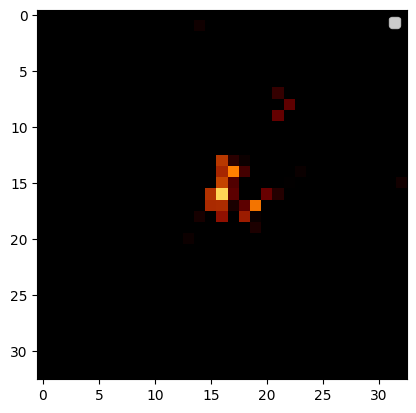

In [16]:
l=16

xmin, xmax = max_pos[0] - l , max_pos[0] +l+1
ymin, ymax = max_pos[1] - l , max_pos[1] +l+1

sub_exprf = exprf[xmin:xmax, ymin:ymax]

plt.imshow(sub_exprf, cmap= 'afmhot')
plt.legend()
plt.clim(11,20)
plt.show()

In [17]:
loc = np.where(sub_exprf > threshold)

In [18]:
print(np.array(loc).T)

[[ 8 22]
 [ 9 21]
 [13 16]
 [14 16]
 [14 17]
 [14 18]
 [15 16]
 [15 17]
 [16 15]
 [16 16]
 [16 17]
 [16 20]
 [17 15]
 [17 16]
 [17 18]
 [17 19]
 [18 16]
 [18 18]]


In [21]:
coor_list = sort_coor_list(exprf, loc)

nn_list =  nearest_neighbours(hl, coor_list)

merged_nn_list, merged_coor_list = merge_nn(coor_list, nn_list)

mass_list = mass_conversion(sub_exprf, threshold, merged_coor_list, merged_nn_list)

In [24]:
print(len(merged_nn_list))
print(len(merged_nn_list['[16 16]']))
# print(nnn_list['[16 16]'].shape)
# print(nnn_list['[16 16]'])
print(mass_list)

2
48
[220.6111602732725, 28.325968554468993]


In [18]:
mass_list = []

for coor in new_coors:
    print(coor, len(nnn_list[f'{coor}']))

    d2_i = sub_exprf[coor[0], coor[1]]
    print(d2_i)

    # Coorindates (x,y) of the merged neighborhood
    x, y  = nnn_list[f'{coor}'][:,0], nnn_list[f'{coor}'][:,1]

    pixel = sub_exprf.shape[0]

    if any(coord <= 0 or coord >= pixel - 1 for coord in coor):
        print(f'found edge case at {coor}, truncating nearest neighbourhood')
        x, y = filtering(x, y, pixel)

    d1_ij = sub_exprf[x,y]

    dM_i = [dM(d1, d2_i, threshold) for d1 in d1_ij]

    mass_list.append( nn_sum(dM_i, d2_i, threshold) )


print(mass_list)

[16 16] 69
15.730711123018471
[7 3] 8
15.056203930660509
[13 10] 25
14.692679428242101
[15  6] 14
14.353414842544984
[10 21] 8
13.33362196682293
[20  6] 11
13.118641482648345
[ 8 21] 13
12.759980460968064
[25  8] 8
12.144309699448025
[24  6] 8
12.098004648738158
[255.20249984060152, 35.05791538463001, 87.32247929035186, 43.26983510304265, 17.241046495531663, 37.94579519288556, 43.441850081356606, 20.729424603514918, 20.04517652225759]


In [ ]:
hc_bare_mass_list = []
hc_cluster_mass_list = []

sc_bare_mass_list = []
sc_cluster_mass_list =[]

nn=0
while True:
    nn+=1
    print(nn)

    exprf = gaussian_to_exp( grf_2d(mean= 0, std_dev = 1, pixel= pixel, amplitude = 1, k_power=k_power), 1)


    pos = np.argwhere(exprf > threshold)
    all_pos = np.argwhere(exprf > sub_threshold)
    #sub_pos = np.argwhere((exprf > sub_threshold) & (exprf < threshold))
    if (pos.shape[0] == 0):
        print("No threshold exceeding events")
        continue

    """
    WARNING: This code will cause error here when the numpy array pos
    is empty. That means that the program is unable to find any
    threshold exceeding events. This will be fixed  in the future when
    incorperating the loops by the continue command.
    """

    # Run clustering algorithm for hard threshold
    hc_labels, hc_clt_pos_dict = DBSCAN_CLUSTERING(data = pos, eps = eps, min_samples = min_samples)
    # Run clustering algorithm for soft threshold
    sc_labels, sc_clt_pos_dict = DBSCAN_CLUSTERING(data = all_pos, eps = eps, min_samples = min_samples)

    # # of clusters soft threshold
    sc_num_clt = len(set(sc_labels))
    # # of clusters hard threshold
    hc_num_clt = len(set(hc_labels))

    # # Color scheme defined bby the total # of clusters
    # sc_cmap = cm.get_cmap('rainbow', sc_num_clt)
    # hc_cmap = cm.get_cmap('rainbow', hc_num_clt)

    # Search for primary neighborhood
    hc_coordinates_nn = find_nearest_neighbours(half_length = 1, labels = hc_labels, clt_pos_dict = hc_clt_pos_dict)
    sc_coordinates_nn = find_nearest_neighbours(half_length = 1, labels = sc_labels, clt_pos_dict = sc_clt_pos_dict)

    # Merge the primary and secondary neighborhoods # Note that "threshold" must always be the one defining the rare event.
    hc_coordinates_nn, hc_clt_pos_dict_merged = merge_nearest_neighbour(exprf = exprf, labels = hc_labels, clt_pos_dict = hc_clt_pos_dict, coordinates_nn = hc_coordinates_nn)
    sc_coordinates_nn, sc_clt_pos_dict_merged = merge_nearest_neighbour(exprf = exprf, labels = sc_labels, clt_pos_dict = sc_clt_pos_dict, coordinates_nn = sc_coordinates_nn)

    hc_cluster_mass_i , hc_cluster_mass_ij = mass_conversion(exprf = exprf, labels = hc_labels, threshold = threshold, clt_pos_dict_merged = hc_clt_pos_dict_merged, coordinates_nn = hc_coordinates_nn)
    sc_cluster_mass_i , sc_cluster_mass_ij = mass_conversion(exprf = exprf, labels = sc_labels, threshold = threshold, clt_pos_dict_merged = sc_clt_pos_dict_merged, coordinates_nn = sc_coordinates_nn)

    hc_bare_mass_i, hc_bare_mass_ij = bare_mass_conversion(exprf = exprf, labels = hc_labels, threshold = threshold, clt_pos_dict = hc_clt_pos_dict)
    sc_bare_mass_i, sc_bare_mass_ij = bare_mass_conversion(exprf = exprf, labels = sc_labels, threshold = threshold, clt_pos_dict = sc_clt_pos_dict)

    for ii in set(sc_labels)-{-1}:
        for item in sc_cluster_mass_ij[ii]:
            sc_cluster_mass_list.append(item)
        for item in sc_bare_mass_ij[ii]:
            sc_bare_mass_list.append(item)

    for ii in set(hc_labels)-{-1}:
        for item in hc_cluster_mass_ij[ii]:
            hc_cluster_mass_list.append(item)
        for item in hc_bare_mass_ij[ii]:
            hc_bare_mass_list.append(item)

    if nn%10000 == 0:

        timenow = datetime.now().strftime("%d%H%M%S")
        np.save(f'hc_cluster_mass_list_{timenow}.npy', hc_cluster_mass_list)
        np.save(f'hc_bare_mass_list_{timenow}.npy', hc_bare_mass_list)
        np.save(f'sc_cluster_mass_list_{timenow}.npy', sc_cluster_mass_list)
        np.save(f'sc_bare_mass_list_{timenow}.npy', sc_bare_mass_list)

        hc_cluster_mass_list=[]
        hc_bare_mass_list=[]
        sc_cluster_mass_list=[]
        sc_bare_mass_list=[]
